# Checkpoint 3

Implement here your algorithm to estimate the parametric field from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- your estimates of parametric field


In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp3

fatal: destination path 'ScientificTools' already exists and is not an empty directory.
/content/ScientificTools/Project1/Cp3


In [3]:
# loading of the dataset

CP3data = np.load("CP3data.npz")
CP3data = CP3data['arr_0']

CP3estimate = np.load("CP3field.npz")
CP3estimate = CP3estimate['arr_0']

In [4]:
ind_disp = 0
x_meas = CP3data[ind_disp][0]
y_meas = CP3data[ind_disp][1]
t_meas = CP3data[ind_disp][2]

speed_field = CP3estimate[ind_disp][0]

In [5]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))

# Find initialization map

In [21]:
index = np.zeros(100)

for i in range(100):
  speed_field = CP3estimate[i][0]

  count = np.sum(speed_field >= 98)
  if count > 0.75 * 151**2:
    index[i] = 1

In [22]:
np.where(index == 1)

(array([64, 87]),)

# KERNEL PCA

In [ ]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler


mesh_size = 151 ** 2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

scaler = StandardScaler()
data_normalized = scaler.fit_transform(A)


kpca = KernelPCA(kernel='linear', n_components=3, fit_inverse_transform=True)
data_kpca = kpca.fit_transform(data_normalized)

data_rec=kpca.inverse_transform(data_kpca)
data_rec_scaled = scaler.inverse_transform(data_rec)


import matplotlib.pyplot as plt

# Plot the original speed field
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(speed_field, cmap='viridis')
plt.title('Original Speed Field')
plt.colorbar()

# Plot the reconstructed data
plt.subplot(1, 2, 2)
plt.imshow(data_rec_scaled, cmap='viridis')
plt.title('Reconstructed Data')
plt.colorbar()

plt.tight_layout()
plt.show()



# AUTOENCODER

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

latent_dim = 5

mesh_size = 151 ** 2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

scaler = StandardScaler()
data_normalized = scaler.fit_transform(A)

input_data = Input(shape=(mesh_size,))
encoded = Dense(latent_dim, activation=None)(input_data)
decoded = Dense(mesh_size, activation=None)(encoded)

# Create the autoencoder model
autoencoder = Model(input_data, decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_normalized.T, data_normalized.T, epochs=500, batch_size=32)

# Extract the encoder part to get the latent representation
encoder = Model(input_data, encoded)


In [ ]:
latent_representations = encoder.predict(data_normalized.T)

reconstructed_A = autoencoder.predict(data_normalized.T)
reconstructed_A_rescaled = scaler.inverse_transform(reconstructed_A.T)

In [ ]:
latent_representations


In [ ]:

import matplotlib.pyplot as plt

# Plot the original speed field
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(A[:,10].reshape(151,151), cmap='viridis')
plt.title('Original Speed Field')
plt.colorbar()

# Plot the reconstructed data
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_A_rescaled[:,10].reshape(151,151), cmap='viridis')
plt.title('Reconstructed Data')
plt.colorbar()

plt.tight_layout()
plt.show()

# SVD and compressed sensing

In [59]:
from sklearn.preprocessing import StandardScaler

mesh_size = 151**2
num_samples = 100
A = np.zeros((mesh_size, num_samples))

for i in range(num_samples):
  A[:, i] = CP3estimate[i][0].flatten()

#scaler = StandardScaler()
#A_normalized = scaler.fit_transform(A)

[U,s,V] = np.linalg.svd(A, full_matrices=False)

Text(0.5, 1.0, 'Explained variance')

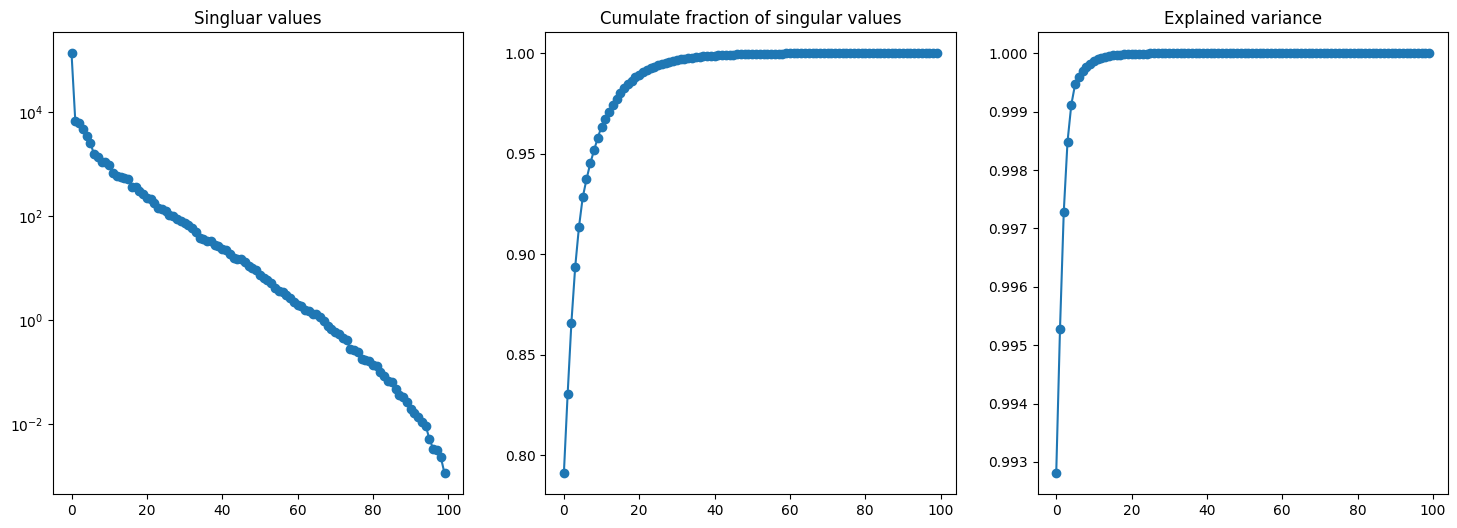

In [60]:
fig, axes = plt.subplots(1, 3, figsize = (18,6))

axes[0].semilogy(s, 'o-')
axes[0].set_title('Singluar values')

axes[1].plot(np.cumsum(s)/np.sum(s), 'o-')
axes[1].set_title('Cumulate fraction of singular values')

axes[2].plot(np.cumsum(s**2)/np.sum(s**2), 'o-')
axes[2].set_title('Explained variance')

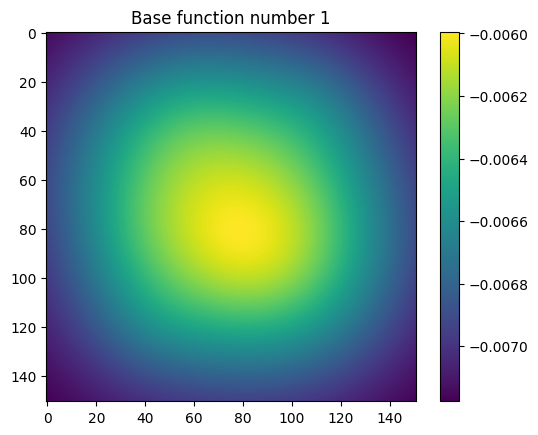

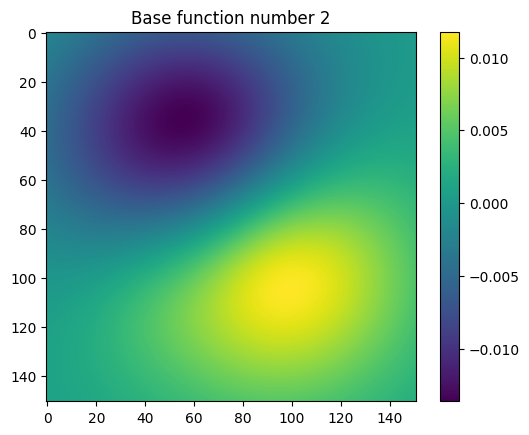

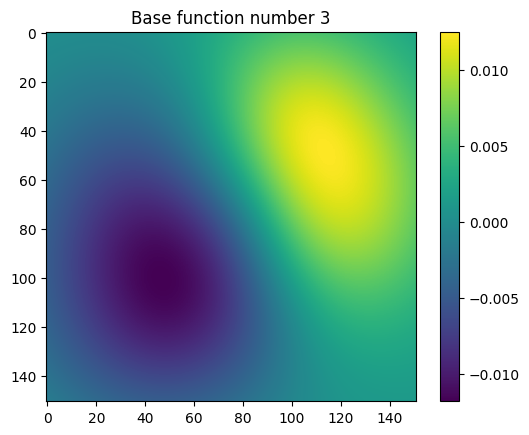

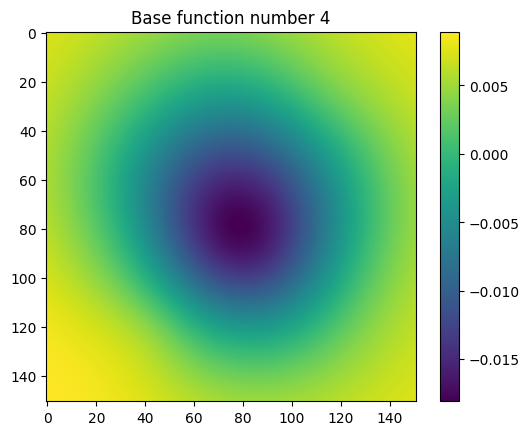

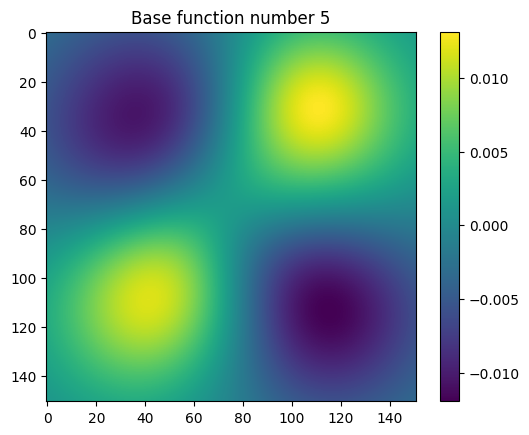

In [61]:
k = 5

for i in range(k):
  U_k = U[:, i].reshape(151, 151)
  plt.imshow(U_k)
  plt.title(f"Base function number {i+1}")
  plt.colorbar()
  plt.show()

In [71]:
p = 100
perm = np.random.choice(mesh_size, size=p, replace=False)

C = np.zeros((p,mesh_size))
for i in range(p):
    C[i,perm[i]] = 1.0

In [72]:
u = A[:,0]
y = C @ u

In [73]:
# compressed sensing problem
k = 100
Psi = U[:, :k]

Theta = C @ Psi

In [74]:
# solving with CVX
import cvxpy as cvx

# Create vector variables (CVXPY Variable)
s_c = cvx.Variable(Psi.shape[1])
# Create the constraints (Python list)
constraints = [Theta @ s_c == y]
# Form objective
obj = cvx.Minimize(cvx.norm(s_c, 1))
# Form and solve problem
prob = cvx.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", s_c.value)

status: optimal
optimal value 17816.62700505865
optimal var [-1.31962838e+04  9.29752715e+02 -1.41611098e+03  2.12838349e+02
 -6.68500839e+02  4.58610996e+02  1.09475360e+02 -8.57869330e+01
 -5.88763841e+01 -3.67632804e+00  1.37995309e+02 -3.32200905e+01
  9.24761999e+01 -6.08357861e+01  5.52969095e+01 -3.18006990e+01
  4.49257683e+01 -7.43738120e+00  6.50373681e+00 -3.09887282e+01
  4.33974683e+00  2.18920518e+01 -2.20963233e+01  8.95104193e+00
  9.49585733e+00 -1.38211657e+01 -6.57713202e+00 -1.81064303e+00
 -1.07476191e+01 -4.58026522e+00  6.22641620e+00  9.28287405e+00
  1.24816862e+01  4.92067258e+00 -8.21179082e+00  2.91983623e+00
 -4.52814381e+00  2.82059304e+00 -1.71022217e+00  8.31922281e-01
 -5.18247319e+00  1.51358587e+00 -6.38203786e-01  7.97130158e-01
 -1.29626888e+00 -7.53784089e-01  1.12386331e+00 -7.96160025e-02
 -4.10936159e-01  7.14016600e-01  7.98696494e-01 -7.80393173e-02
 -4.29556838e-01 -2.34063662e-01 -1.82586737e-01  5.37915024e-02
  3.40795090e-01  2.97755115e-

[-13196.28384052    929.75271479  -1416.1109831     212.83834891
   -668.50083878]


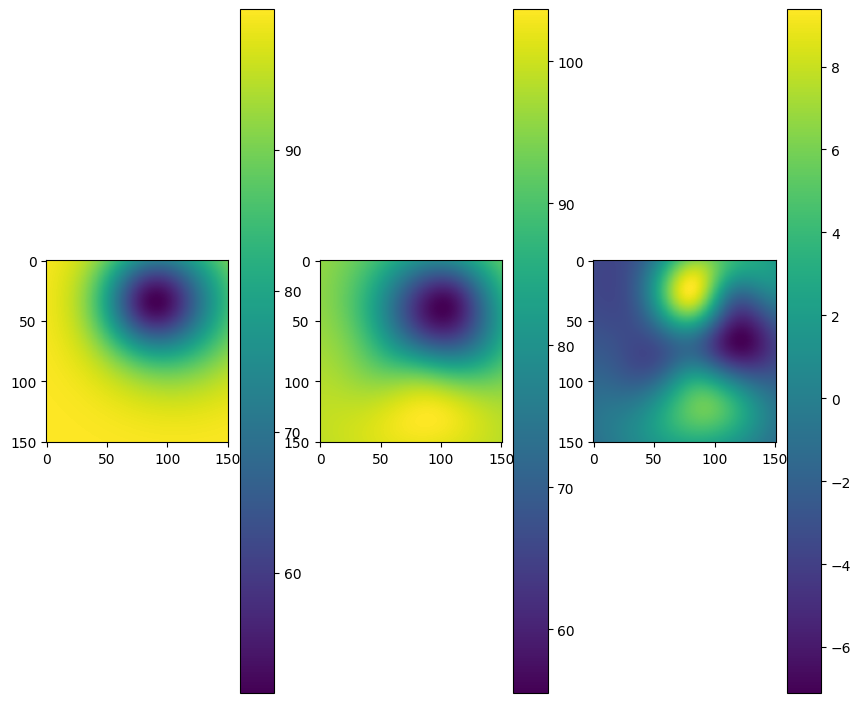

In [75]:
k = 5
n = 151

bases = Psi[:, :k]
coef = s_c.value[:k]

urec = bases @ coef

print(coef)
fig,axs = plt.subplots(1,3, figsize = (10, 30))

im0 = axs[0].imshow( np.reshape(u,(n,n) ) )
plt.colorbar(im0)

im1 = axs[1].imshow( np.reshape(urec,(n,n) ) )
plt.colorbar(im1)

im2 = axs[2].imshow( np.reshape(urec-u,(n,n) ) )
plt.colorbar(im2)

# PINN

In [ ]:
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

!pip -q install pyDOE
from pyDOE import lhs

# set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# collocation points
Ncl = 151**2
Xcl = lhs(2,Ncl)
xcl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,0],dtype=tf.float64),axis=-1)
ycl = tf.expand_dims(tf.cast(-1.5+(3.0)*Xcl[:,1],dtype=tf.float64),axis=-1)
X_coll = tf.concat([xcl,ycl],1)

In [ ]:
# PINN loss function
def loss(xcl,ycl,xmeas,ymeas,umeas,coeff):
    input_data=tf.concat([xmeas,ymeas],1)
    umeas_pred = PINN(input_data)
    r_pred   = r_PINN(xcl,ycl,coeff)

    # loss components
    mse_meas  = tf.reduce_mean(tf.pow(umeas-umeas_pred,2))
    mse_r  = tf.reduce_mean(tf.pow(r_pred,2))

    # bc
    y0 = tf.constant([-0.50784787],dtype=tf.float64)
    mse_bc= tf.pow( PINN( tf.transpose( tf.stack( [tf.constant([1.5],dtype=tf.float64), y0] ) ) ) ,2)

    return mse_meas + mse_r + mse_bc

# residual computation based on AD
@tf.function
def r_PINN(x,y,coeff):
    input_data=tf.concat([x,y],1)
    u = PINN(input_data)
    u_x = tf.gradients(u,x)[0]
    u_y = tf.gradients(u,y)[0]
    u_grad = tf.transpose(tf.concat([u_x, u_y], axis=1))

    pi = tf.constant(np.pi,dtype=tf.float64)
    theta_fiber = tf.constant([0.11629039] ,dtype=tf.float64)
    a_ratio = tf.constant([5.26792418], dtype=tf.float64)
    theta0 = pi/2 - theta_fiber

    a = tf.stack([tf.cos(theta0), tf.sin(theta0)])
    b = tf.stack([tf.cos(theta0-pi/2), tf.sin(theta0-pi/2)])

    D_00 = 1 / a_ratio * a[0]**2 + b[0]**2
    D_01 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_10 = 1 / a_ratio * a[0] * a[1] + b[0] * b[1]
    D_11 = 1 / a_ratio * a[1]**2 + b[1]**2

    return (bases@coeff) * tf.sqrt(((u_x * D_00 * u_x + u_x * D_01 * u_y + u_y * D_10 * u_x + u_y * D_11 * u_y)))  - 1


# neural network weight gradients
@tf.function
def grad(model,xcl,ycl,xmeas,ymeas,umeas,coeff):
    with tf.GradientTape(persistent=True) as tape:
        loss_value = loss(xcl,ycl,xmeas,ymeas,umeas,coeff)
        grads = tape.gradient(loss_value,model.trainable_variables)
        grads_weight= tape.gradient(loss_value,coeff)
    return loss_value, grads, grads_weight

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM

regularization_strength = 1e-3

PINN = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,),
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    #tf.keras.layers.Reshape((1, 64)),

    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 64)),

    tf.keras.layers.Dense(128, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(32, activation='relu',
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation=None,
                          kernel_initializer="glorot_uniform",
                          kernel_regularizer=regularizers.l2(regularization_strength),
                          dtype=tf.float64)
])

In [ ]:
#selected values  [0.10337211, 4.95760936, -0.50074575]  [0.12920869, 5.57823901, -0.51495002]
print((0.10337211+0.12920869)/2, ( 4.95760936+5.57823901)/2, (-0.50074575+-0.5149500)/2)

In [ ]:
def checkpoint2_solution( x, y , t ):

  xmeas_train, xmeas_val, ymeas_train, ymeas_val, tmeas_train, tmeas_val = train_test_split(x, y, t, test_size=0.05)
  xmeas_train = tf.constant(xmeas_train.reshape(19, 1), dtype=tf.float64)
  ymeas_train = tf.constant(ymeas_train.reshape(19, 1), dtype=tf.float64)
  tmeas_train = tf.constant(tmeas_train.reshape(19, 1), dtype=tf.float64)
  xmeas_val = tf.constant(xmeas_val.reshape(1, 1), dtype=tf.float64)
  ymeas_val = tf.constant(ymeas_val.reshape(1, 1), dtype=tf.float64)
  tmeas_val = tf.constant(tmeas_val.reshape(1, 1), dtype=tf.float64)

  X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))

  coeff=tf.Variable([[100],[100],[100],[100],[100]], trainable=True, dtype=tf.float64)

  pinn_optimizer = tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.99)
  pinn_optimizer.build(PINN.trainable_variables)

  coeff_optimizer = tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.99)
  coeff_optimizer.build([coeff])

  """
  patience = float('inf')
  patience_lr= float('inf')
  min_delta = 1e-9
  best_val_loss = float('inf')
  wait = 0
  count = 0
  """

  print()
  for iter in range(4000):

    loss_value,grads,grads_weight = grad(PINN,xcl,ycl,xmeas_train, ymeas_train, tmeas_train,coeff)

    pinn_optimizer.apply_gradients(zip(grads,PINN.trainable_variables))
    coeff_optimizer.apply_gradients(zip(grads_weight,[coeff]))

    loss_value_val, _, _ = grad(PINN, xcl, ycl, xmeas_val, ymeas_val, tmeas_val,coeff)

    """
    best_weigths = None
    best_params = None

    # Early stopping
    if loss_value_val < best_val_loss - min_delta:
        best_val_loss = loss_value_val
        wait = 0
        count = 0
        best_weights = PINN.get_weights()
        best_params = theta_fiber.numpy()
    else:
        wait += 1
        count += 1

        if count >= patience_lr:
          tf_optimizer.learning_rate = tf_optimizer.learning_rate * 0.9
          count = 0

        if wait >= patience:
            print('Early stopping at epoch', iter + 1)
            break
    """


    if ((iter+1) % 100 == 0):
      print('iter =  '+str(iter+1))
      tf.print('loss =' , loss_value)
      tf.print('loss_val_param =' , loss_value_val)

      print(coeff.numpy())
      print()

  return coeff

In [ ]:
weights = checkpoint2_solution(x_meas, y_meas , t_meas)


iter =  100
loss = [[1.0711433926839455]]
loss_val_param = [[1.0783635627681507]]
[[99.62974444]
 [99.62974444]
 [99.62974444]
 [99.62974444]
 [99.62974444]]

iter =  200
loss = [[1.0175793838133973]]
loss_val_param = [[1.0182696476947961]]
[[99.42135819]
 [99.42135819]
 [99.42135819]
 [99.42135819]
 [99.42135819]]

iter =  300
loss = [[1.0073444872760371]]
loss_val_param = [[1.0070097244637419]]
[[99.31093992]
 [99.31093992]
 [99.31093992]
 [99.31093992]
 [99.31093992]]

iter =  400
loss = [[1.0030676944012511]]
loss_val_param = [[1.0023265822234357]]
[[99.25384717]
 [99.25384717]
 [99.25384717]
 [99.25384717]
 [99.25384717]]

iter =  500
loss = [[1.0011793879349131]]
loss_val_param = [[1.0008676906776925]]
[[99.22638105]
 [99.22638105]
 [99.22638105]
 [99.22638105]
 [99.22638105]]

iter =  600
loss = [[1.0008987802383953]]
loss_val_param = [[1.0006542291206133]]
[[99.21354019]
 [99.21354019]
 [99.21354019]
 [99.21354019]
 [99.21354019]]

iter =  700
loss = [[1.000840590788755]]
loss

KeyboardInterrupt: 

In [ ]:
vel_map=bases@coeff

# signature of the function

def checkpoint3_solution( x, y , t ):

return speed_field



In [ ]:

def checkpoint3_solution( x, y , t ):

    speed_field = 0

    return speed_field

speed_field = checkpoint2_solution( x_meas, y_meas , t_meas )